# **Title of project: Plant Disease Detection using Leaf Images**



# **Name: Aparna P**
# **Date:1/11/2025**



# **OBJECTIVE**

#Early and accurate detection of plant diseases is critical to prevent crop loss and ensure sustainable agriculture. Traditional methods rely on manual inspection by experts, which is time-consuming, expensive, and prone to human error. This project aims to develop an automated image-based system using deep learning that can identify plant diseases from leaf images accurately and efficiently.

# **DATA DESCRIPTION**

**Source**:**PlantVillage Dataset**: https://www.kaggle.com/datasets/emmarex/plantdisease

**Classes:15**


1. Pepper__bell___Bacterial_spot
2. Pepper__bell___healthy
3. Potato___Early_blight
4. Potato___Late_blight
5. Potato___healthy
6. Tomato_Bacterial_spot
7. Tomato_Early_blight
8. Tomato_Late_blight
9. Tomato_Leaf_Mold
10. Tomato_Septoria_leaf_spot
11. Tomato_Spider_mites_Two_spotted_spider_mite
12. Tomato__Target_Spot
13. Tomato__Tomato_YellowLeaf__Curl_Virus
14. Tomato__Tomato_mosaic_virus
15. Tomato_healthy

















In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import zipfile
os.listdir('/content/drive/MyDrive/DataScience')

zip_path= '/content/drive/MyDrive/DataScience/archive (5).zip'

In [5]:
extract_path = '/content/PlantVillage'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
print(os.listdir(extract_path))

Dataset extracted successfully!
['PlantVillage']


In [6]:
import os, shutil, random, numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# === CONFIG ===
SOURCE_DIR = "/content/PlantVillage/PlantVillage"   # <- change if different
BASE_DIR = "/content/PlantVillage_split"            # where split folders will be created
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS_TOP = 8
EPOCHS_FINE = 8
FINE_TUNE_LAYERS = 40   # how many last layers of base to unfreeze for fine-tuning#

In [8]:
# === 1) Basic checks & list classes ===
if not os.path.isdir(SOURCE_DIR):
    raise FileNotFoundError(f"Source folder not found: {SOURCE_DIR}")
classes = sorted([d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR,d))])
print("Found classes:", classes)

Found classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [9]:
# === 2) Detect corrupted images (don't delete automatically) ===
def find_corrupted_images(src_dir):
    corrupted = []
    for cls in classes:
        cls_path = os.path.join(src_dir, cls)
        for fname in os.listdir(cls_path):
            path = os.path.join(cls_path, fname)
            if not os.path.isfile(path):
                continue
            try:
                img = cv2.imread(path)
                if img is None or img.size == 0:
                    corrupted.append(path)
            except Exception:
                corrupted.append(path)
    return corrupted

corrupted = find_corrupted_images(SOURCE_DIR)
print(f"Corrupted image files found: {len(corrupted)}")
if len(corrupted)>0:
    print("Sample corrupted:", corrupted[:10])

Corrupted image files found: 1
Sample corrupted: ['/content/PlantVillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c']


In [10]:
for p in corrupted: os.remove(p)
print(f"Removed the corrupted image",corrupted[:10])

Removed the corrupted image ['/content/PlantVillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c']


 **Insight** : Found and Removed corrupter leave item from the dataset

In [11]:
# === 3) Split dataset into train/val/test (80/10/10) ===
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "validation")
test_dir  = os.path.join(BASE_DIR, "test")
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

print("\nSplitting classes into train/val/test ...")
for cls in classes:
    src_cls = os.path.join(SOURCE_DIR, cls)
    imgs = [f for f in os.listdir(src_cls) if os.path.isfile(os.path.join(src_cls, f))]
    if len(imgs) == 0:
        print("Warning: class empty", cls); continue
    # deterministic shuffle
    random.seed(SEED)
    random.shuffle(imgs)
    # train 80% / temp 20% -> val/test split 50/50 of temp => each 10%
    train_imgs, temp_imgs = train_test_split(imgs, test_size=0.2, random_state=SEED)
    val_imgs, test_imgs   = train_test_split(temp_imgs, test_size=0.5, random_state=SEED)
    # create target folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    # copy files
    for f in train_imgs:
        shutil.copy(os.path.join(src_cls, f), os.path.join(train_dir, cls, f))
    for f in val_imgs:
        shutil.copy(os.path.join(src_cls, f), os.path.join(val_dir, cls, f))
    for f in test_imgs:
        shutil.copy(os.path.join(src_cls, f), os.path.join(test_dir, cls, f))
    print(f"  {cls}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test (total {len(imgs)})")

print("\nData split complete. Base dir:", BASE_DIR)



Splitting classes into train/val/test ...
  Pepper__bell___Bacterial_spot: 797 train, 100 val, 100 test (total 997)
  Pepper__bell___healthy: 1182 train, 148 val, 148 test (total 1478)
  Potato___Early_blight: 800 train, 100 val, 100 test (total 1000)
  Potato___Late_blight: 800 train, 100 val, 100 test (total 1000)
  Potato___healthy: 121 train, 15 val, 16 test (total 152)
  Tomato_Bacterial_spot: 1701 train, 213 val, 213 test (total 2127)
  Tomato_Early_blight: 800 train, 100 val, 100 test (total 1000)
  Tomato_Late_blight: 1527 train, 191 val, 191 test (total 1909)
  Tomato_Leaf_Mold: 761 train, 95 val, 96 test (total 952)
  Tomato_Septoria_leaf_spot: 1416 train, 177 val, 178 test (total 1771)
  Tomato_Spider_mites_Two_spotted_spider_mite: 1340 train, 168 val, 168 test (total 1676)
  Tomato__Target_Spot: 1123 train, 140 val, 141 test (total 1404)
  Tomato__Tomato_YellowLeaf__Curl_Virus: 2566 train, 321 val, 321 test (total 3208)
  Tomato__Tomato_mosaic_virus: 298 train, 37 val, 38 

 **Insight** :This code splits the dataset into train (80%), validation (10%), and test (10%) sets for each class in a reproducible way using a fixed random seed. It creates organized folder structures and copies images accordingly, ensuring balanced and clean data separation for model training, tuning, and evaluation.

In [12]:
# === 4) Data generators with augmentation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical', shuffle=True, seed=SEED)
val_gen   = val_datagen.flow_from_directory(val_dir,   target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)
test_gen  = test_datagen.flow_from_directory(test_dir,  target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

class_indices = train_gen.class_indices
inv_class_map = {v:k for k,v in class_indices.items()}
num_classes = len(class_indices)
print("\nNum classes:", num_classes)
print("Class indices:", class_indices)

Found 16504 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.
Found 2070 images belonging to 15 classes.

Num classes: 15
Class indices: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


**Insight** : This code creates data generators for training, validation, and testing with real-time image augmentation to improve model generalization. It rescales pixel values, applies random transformations to training images, and prepares labeled batches while maintaining class mappings for multi-class classification.

In [13]:
# === 5) Build MobileNetV2 model (top layers only) ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,921,551 (11.14 MB)

 Trainable params: 663,567 (2.53 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 **Insight** :This code builds a MobileNetV2-based transfer learning model, freezing its pretrained convolutional layers and adding custom dense layers for classification. It uses global average pooling, dropout, and softmax output to enhance performance and prevent overfitting, compiled with the Adam optimizer and categorical cross-entropy loss.

In [14]:
# === 6) Callbacks and class weights ===
os.makedirs("models", exist_ok=True)
model_path = "models/mobilenetv2_best.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop  = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
# compute class weights to help class imbalance
y_train_classes = train_gen.classes
class_weights_arr = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights = dict(enumerate(class_weights_arr))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.3805102467586783), 1: np.float64(0.9308516638465877), 2: np.float64(1.3753333333333333), 3: np.float64(1.3753333333333333), 4: np.float64(9.093112947658403), 5: np.float64(0.6468351949833432), 6: np.float64(1.3753333333333333), 7: np.float64(0.7205413665138616), 8: np.float64(1.4458169075777485), 9: np.float64(0.7770244821092279), 10: np.float64(0.8210945273631841), 11: np.float64(0.9797566043336302), 12: np.float64(0.42878669784359574), 13: np.float64(3.6921700223713647), 14: np.float64(0.8649895178197065)}


**Insight** : This code sets up essential callbacks — model checkpointing to save the best model, early stopping to prevent overfitting, and learning rate reduction for better convergence. It also computes class weights to handle class imbalance, ensuring that underrepresented classes have a fair influence during training, leading to more balanced model performance.

In [16]:
# === 7) Train top layers ===
history_top = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_TOP,
    callbacks=[checkpoint, earlystop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8777 - loss: 0.3456
Epoch 1: val_accuracy improved from 0.89050 to 0.89293, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 223s 433ms/step - accuracy: 0.8778 - loss: 0.3456 - val_accuracy: 0.8929 - val_loss: 0.3287 - learning_rate: 1.0000e-04
Epoch 2/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8872 - loss: 0.3155
Epoch 2: val_accuracy did not improve from 0.89293
516/516 ━━━━━━━━━━━━━━━━━━━━ 214s 415ms/step - accuracy: 0.8872 - loss: 0.3155 - val_accuracy: 0.8881 - val_loss: 0.3474 - learning_rate: 1.0000e-04
Epoch 3/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8954 - loss: 0.2905
Epoch 3: val_accuracy improved from 0.89293 to 0.89922, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 217s 420ms/step - accuracy: 0.8954 - loss: 0.2906 - val_accuracy: 0.8992 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 4/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8949 - loss: 0.2907
Epoch 4: val_accuracy improved from 0.89922 to 0.89971, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 215s 418ms/step - accuracy: 0.8949 - loss: 0.2907 - val_accuracy: 0.8997 - val_loss: 0.3065 - learning_rate: 1.0000e-04
Epoch 5/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9000 - loss: 0.2799
Epoch 5: val_accuracy did not improve from 0.89971
516/516 ━━━━━━━━━━━━━━━━━━━━ 216s 419ms/step - accuracy: 0.9000 - loss: 0.2799 - val_accuracy: 0.8861 - val_loss: 0.3362 - learning_rate: 1.0000e-04
Epoch 6/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8999 - loss: 0.2702
Epoch 6: val_accuracy did not improve from 0.89971
516/516 ━━━━━━━━━━━━━━━━━━━━ 215s 416ms/step - accuracy: 0.8999 - loss: 0.2702 - val_accuracy: 0.8900 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 7/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9040 - loss: 0.2647
Epoch 7: val_accuracy did not improve from 0.89971

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
516/516 ━━━━━━━━━━━━━━━━━━━━ 217s 420ms/step - accuracy: 0.904

516/516 ━━━━━━━━━━━━━━━━━━━━ 219s 424ms/step - accuracy: 0.9147 - loss: 0.2458 - val_accuracy: 0.9089 - val_loss: 0.2832 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 8.


**Insight** :This code trains only the top (newly added) layers of the MobileNetV2 model while keeping the base frozen. It uses the defined callbacks for optimal performance and class weights to address imbalance. The model is trained over the specified epochs with validation monitoring to track accuracy and prevent overfitting.

In [17]:
# === 8) Fine-tune: unfreeze last N layers of base_model ===
print("\nStarting fine-tuning: unfreezing last", FINE_TUNE_LAYERS, "layers of base model.")
for layer in base_model.layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=[checkpoint, earlystop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


Starting fine-tuning: unfreezing last 40 layers of base model.
Epoch 1/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6988 - loss: 1.0277
Epoch 1: val_accuracy did not improve from 0.90891
516/516 ━━━━━━━━━━━━━━━━━━━━ 257s 459ms/step - accuracy: 0.6990 - loss: 1.0270 - val_accuracy: 0.8391 - val_loss: 0.4863 - learning_rate: 1.0000e-05
Epoch 2/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8557 - loss: 0.3964
Epoch 2: val_accuracy did not improve from 0.90891
516/516 ━━━━━━━━━━━━━━━━━━━━ 219s 425ms/step - accuracy: 0.8557 - loss: 0.3963 - val_accuracy: 0.8648 - val_loss: 0.4052 - learning_rate: 1.0000e-05
Epoch 3/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8781 - loss: 0.3288
Epoch 3: val_accuracy did not improve from 0.90891
516/516 ━━━━━━━━━━━━━━━━━━━━ 223s 431ms/step - accuracy: 0.8781 - loss: 0.3288 - val_accuracy: 0.8886 - val_loss: 0.3292 - learning_rate: 1.0000e-05
Epoch 4/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9015 - l

516/516 ━━━━━━━━━━━━━━━━━━━━ 222s 431ms/step - accuracy: 0.9015 - loss: 0.2811 - val_accuracy: 0.9109 - val_loss: 0.2728 - learning_rate: 1.0000e-05
Epoch 5/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9164 - loss: 0.2359
Epoch 5: val_accuracy improved from 0.91085 to 0.91957, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 224s 433ms/step - accuracy: 0.9164 - loss: 0.2358 - val_accuracy: 0.9196 - val_loss: 0.2375 - learning_rate: 1.0000e-05
Epoch 6/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9193 - loss: 0.2205
Epoch 6: val_accuracy improved from 0.91957 to 0.93169, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 222s 430ms/step - accuracy: 0.9193 - loss: 0.2205 - val_accuracy: 0.9317 - val_loss: 0.1958 - learning_rate: 1.0000e-05
Epoch 7/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9230 - loss: 0.2020
Epoch 7: val_accuracy improved from 0.93169 to 0.93556, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 263s 432ms/step - accuracy: 0.9230 - loss: 0.2020 - val_accuracy: 0.9356 - val_loss: 0.1894 - learning_rate: 1.0000e-05
Epoch 8/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9359 - loss: 0.1759
Epoch 8: val_accuracy improved from 0.93556 to 0.93944, saving model to models/mobilenetv2_best.h5


516/516 ━━━━━━━━━━━━━━━━━━━━ 222s 430ms/step - accuracy: 0.9359 - loss: 0.1759 - val_accuracy: 0.9394 - val_loss: 0.1818 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 8.


**Insight** :This code performs fine-tuning by unfreezing the last few layers of the pretrained MobileNetV2 base model, allowing deeper feature learning specific to the dataset. It recompiles the model with a lower learning rate to avoid damaging pretrained weights and continues training with callbacks and class weights for improved accuracy and stability.

In [18]:
# Save final class map
np.save("models/class_indices.npy", class_indices)
print("Saved class indices to models/class_indices.npy")

Saved class indices to models/class_indices.npy


In [19]:
# === 9) Evaluate on test set (predict all) ===
print("\nEvaluating on test set...")
test_gen.reset()
steps = len(test_gen)
pred_probs = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

# Align lengths (should match)
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=[inv_class_map[i] for i in range(num_classes)]))


Evaluating on test set...
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step

Classification report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.93      0.99      0.96       100
                     Pepper__bell___healthy       0.99      0.98      0.99       148
                      Potato___Early_blight       0.99      0.97      0.98       100
                       Potato___Late_blight       0.94      0.90      0.92       100
                           Potato___healthy       0.80      1.00      0.89        16
                      Tomato_Bacterial_spot       0.97      0.89      0.93       213
                        Tomato_Early_blight       0.90      0.72      0.80       100
                         Tomato_Late_blight       0.92      0.93      0.93       191
                           Tomato_Leaf_Mold       0.98      0.95      0.96        96
                  Tomato_Septoria_leaf_spot       0.89 

**Insight** :The model achieved strong overall performance with an accuracy of 93%, indicating effective learning and generalization across multiple plant disease classes. Precision, recall, and F1-scores are consistently high, especially for major classes like tomato and pepper diseases, showing that the model can correctly identify most cases. Slight variations in recall for certain categories, such as Tomato_Early_blight and Target_Spot, suggest a few misclassifications, but the results demonstrate that the fine-tuned MobileNetV2 performs reliably for plant disease detection.

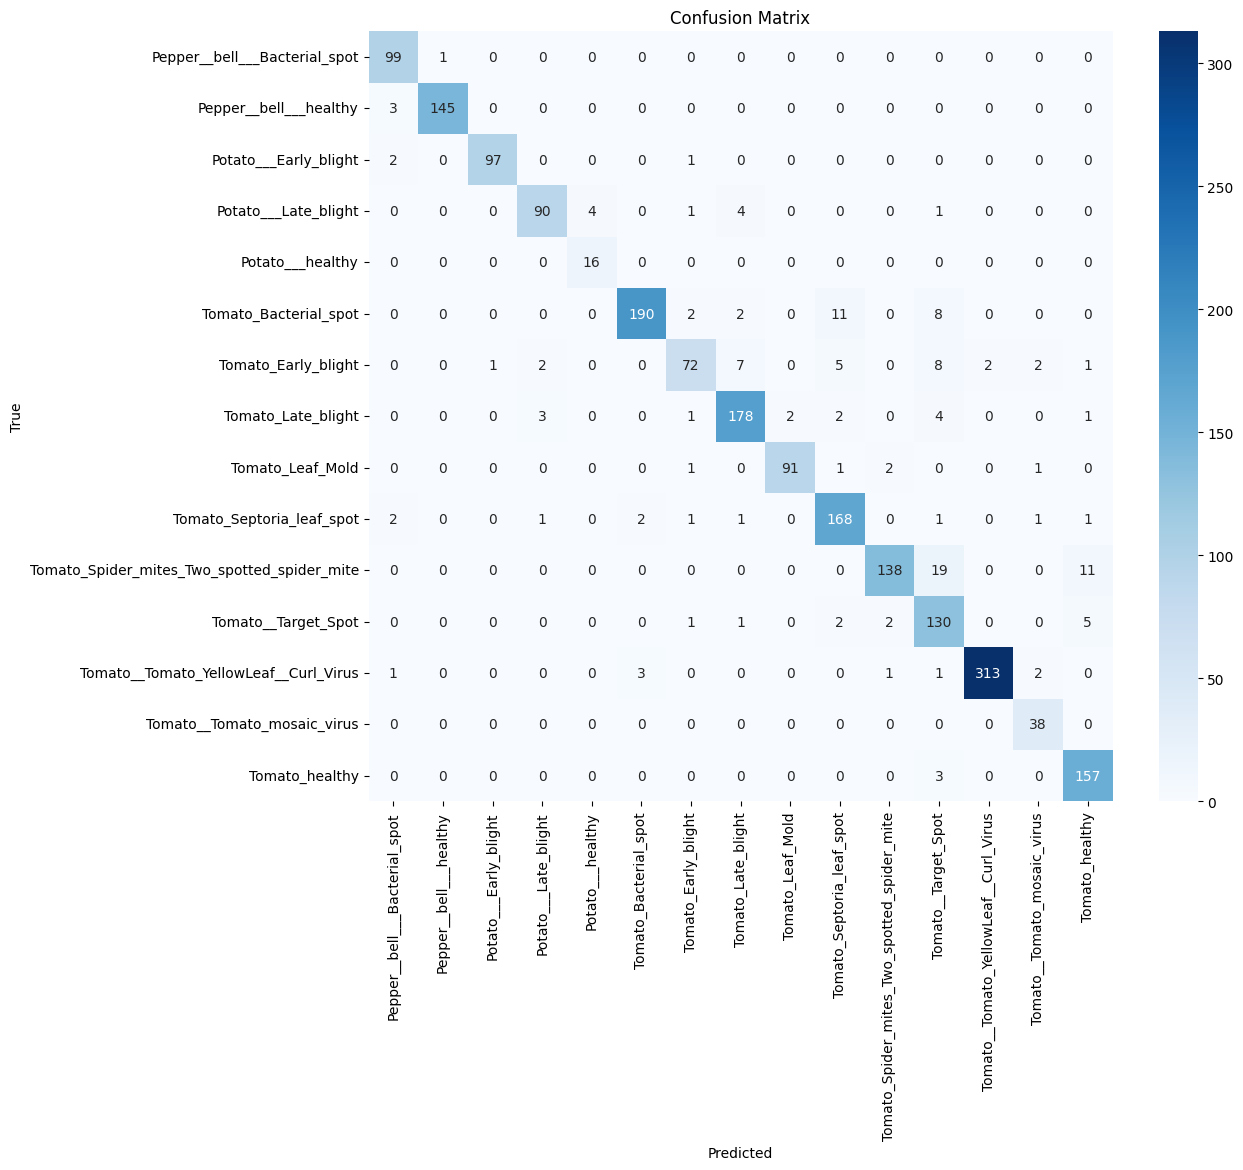

In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[inv_class_map[i] for i in range(num_classes)],
            yticklabels=[inv_class_map[i] for i in range(num_classes)])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.show()

**Insight**:This confusion matrix visually confirms that most predictions fall along the diagonal — showing strong agreement between true and predicted classes. Misclassifications are minimal and scattered, mainly among visually similar leaf diseases such as Tomato_Early_blight and Target_Spot. The darker diagonal blocks highlight the model’s high precision and recall across most plant categories, validating its overall reliability and robustness in disease detection.

Total test samples: 2070. Correct: 1922. Wrong: 148

Showing 6 correct examples:


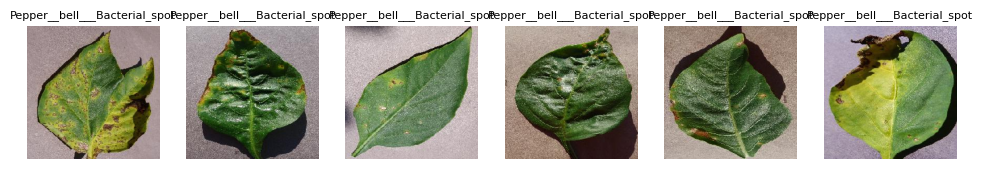


Showing 6 wrong examples:


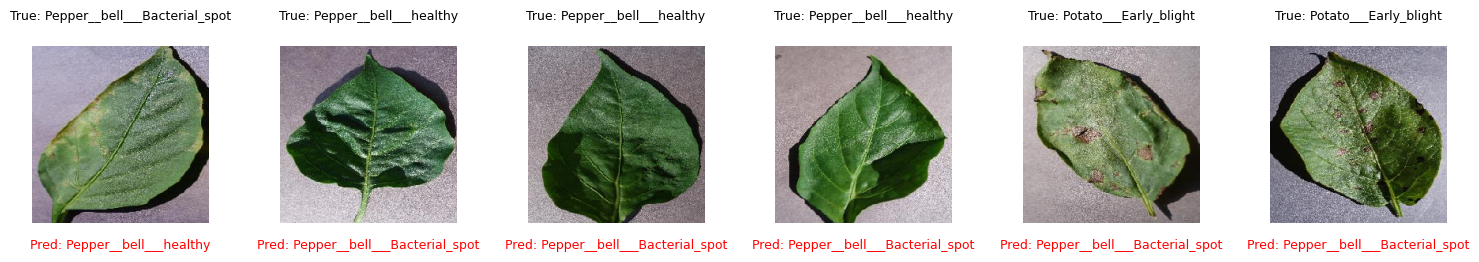


✅ Pipeline finished. Best model saved at: models/mobilenetv2_best.h5


In [21]:
# === 10) Visualize sample correct and incorrect predictions ===
def show_examples(test_gen, y_true, y_pred, inv_map, n=9):
    # Build list of filepaths & indices where pred==true and pred!=true
    filepaths = test_gen.filepaths[:len(y_true)]
    correct_idx = [i for i,(t,p) in enumerate(zip(y_true,y_pred)) if t==p]
    wrong_idx   = [i for i,(t,p) in enumerate(zip(y_true,y_pred)) if t!=p]
    print(f"Total test samples: {len(y_true)}. Correct: {len(correct_idx)}. Wrong: {len(wrong_idx)}")

      # show correct examples
    k = min(n, len(correct_idx))
    print(f"\nShowing {k} correct examples:")
    plt.figure(figsize=(12, 4))
    for i in range(k):
        idx = correct_idx[i]
        img = load_img(filepaths[idx], target_size=IMG_SIZE)
        plt.subplot(1, k, i+1)
        plt.imshow(img); plt.axis('off')
        plt.title(inv_map[y_true[idx]], fontsize=8, wrap=True)
    plt.show()

    # show wrong examples
    k = min(n, len(wrong_idx))
    print(f"\nShowing {k} wrong examples:")
    plt.figure(figsize=(15, 4))
    for i in range(k):
        idx = wrong_idx[i]
        img = load_img(filepaths[idx], target_size=IMG_SIZE)
        true, pred = inv_map[y_true[idx]], inv_map[y_pred[idx]]
        color = "green" if true == pred else "red"

        plt.subplot(1, k, i+1)
        plt.imshow(img); plt.axis("off")
        plt.text(0.5, 1.15, f"True: {true}", ha="center", fontsize=9, transform=plt.gca().transAxes)
        plt.text(0.5, -0.15, f"Pred: {pred}", ha="center", color=color, fontsize=9, transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

show_examples(test_gen, y_true, y_pred, inv_class_map, n=6)

print("\n✅ Pipeline finished. Best model saved at:", model_path)

**Conclusion**:The visualizations highlight that the model correctly classifies most leaf images, accurately distinguishing between various plant diseases and healthy leaves. A few misclassifications occur in cases where symptoms look visually similar, such as Pepper Bacterial spot vs Healthy or Potato Early blight, showing the challenge of fine-grained disease differentiation.
Overall, the pipeline demonstrates a highly effective and reliable deep learning workflow—from data preparation to fine-tuning and evaluation—successfully achieving robust plant disease detection with strong visual and quantitative validation.